# clEsperanto
[clEsperanto](http://clesperanto.net) is a project between multiple bio-image analysis ecosystem aiming at removing language barriers. It is based on [OpenCL](https://www.khronos.org/opencl/), an open standard for programming graphics processing units (GPUs, and more) and its python wrapper [pyopencl](https://documen.tician.de/pyopencl/). Under the hood, it uses processing kernels originating from the [clij](https://clij.github.io) project.

See also
* [GPU-accelerated image analysis in Fiji and Napari, EuroBioimaging Virtual Pub](https://www.youtube.com/watch?v=MERVnf5_QkI)
* [pyclesperanto-prototype](https://github.com/clEsperanto/pyclesperanto_prototype)
* [pyclesperanto API](https://clij.github.io/clij2-docs/reference__pyclesperanto)
* [Napari pyclesperanto Assistant](https://clesperanto.github.io/napari_pyclesperanto_assistant/)

## GPU Initialization
We'll start with initializing checking out what GPUs are installed:

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import stackview

# list available devices
cle.available_device_names()

['NVIDIA GeForce RTX 3050 Ti Laptop GPU',
 'gfx1035',
 'cupy backend (experimental)']

In [2]:
# select a specific device with only a part of its name
cle.select_device("2080")

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\pyclesperanto_prototype\_tier0\_device.py:77: UserWarning: No OpenCL device found with 2080 in their name. Using gfx1035 instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

In [3]:
# check which device is uses right now
cle.get_device()

<gfx1035 on Platform: AMD Accelerated Parallel Processing (2 refs)>

## Processing images
For loading image data, we use scikit-image as usual:

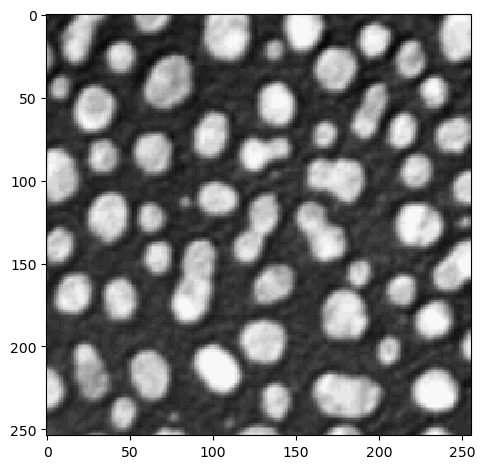

In [4]:
from skimage.io import imread, imshow

image = imread("../../data/blobs.tif")
imshow(image)

The `cle.` gateway has all methods you need, it does not have sub-packages:

cl.OCLArray([[ 41.428753,  34.696438,  27.733936, ..., 220.92714 , 211.21164 ,
        206.71573 ],
       [ 47.421425,  38.878723,  30.323011, ..., 228.32323 , 220.60194 ,
        216.83534 ],
       [ 48.121437,  40.610855,  33.357384, ..., 235.32935 , 229.7049  ,
        226.88821 ],
       ...,
       [ 74.4386  ,  76.32904 ,  77.03725 , ...,  48.000324,  48.00075 ,
         48.001007],
       [ 81.793655,  81.17787 ,  79.80763 , ...,  48.      ,  48.      ,
         48.      ],
       [ 88.816925,  85.382095,  81.478806, ...,  48.      ,  48.      ,
         48.      ]], dtype=float32)
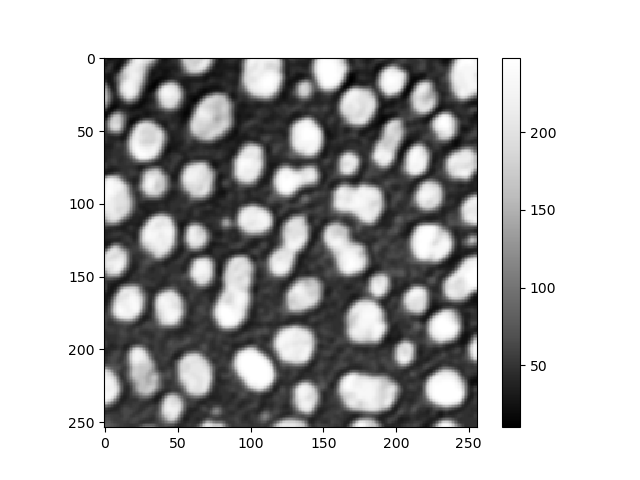
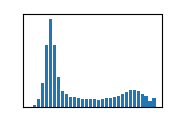

In [5]:
# noise removal
blurred = cle.gaussian_blur(image, sigma_x=1, sigma_y=1)
blurred

cl.OCLArray([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
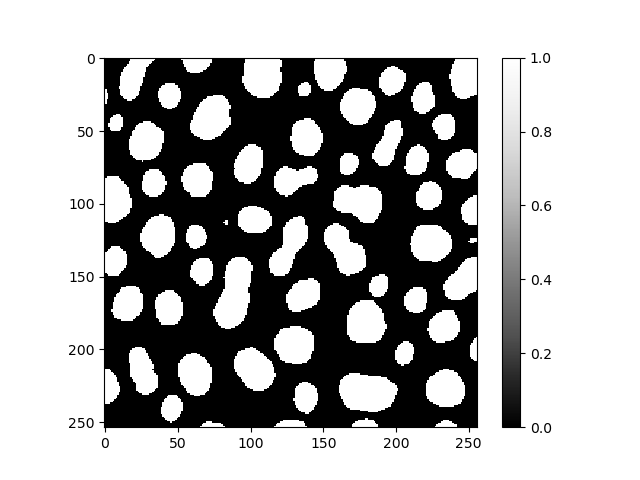
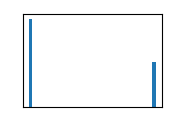

In [6]:
# binarization
binary = cle.threshold_otsu(blurred)
binary

cl.OCLArray([[ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       [ 0,  0,  0, ..., 59, 59, 59],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
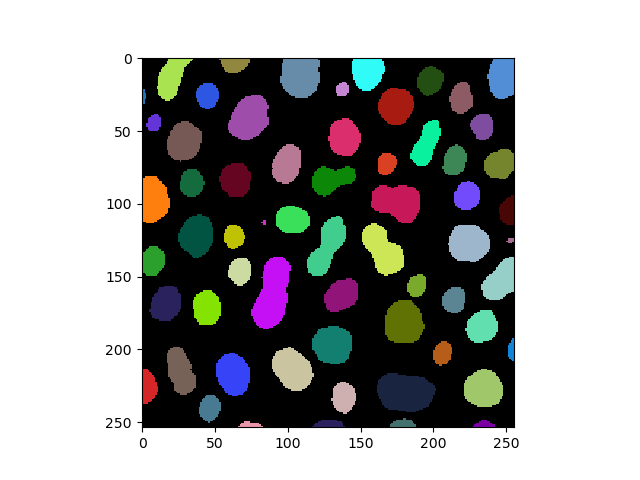

In [7]:
# labeling
labels = cle.connected_components_labeling_box(binary)
labels

C:\Users\haase\mambaforge\envs\bio39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


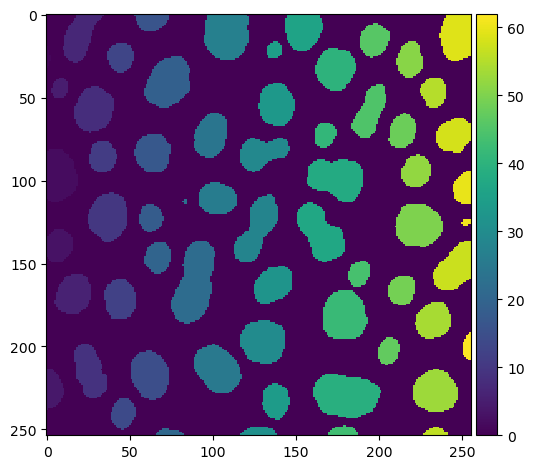

In [8]:
# visualize results
imshow(labels)

`stackview` also comes with an imshow function, that allows for example showing label images more conveniently:

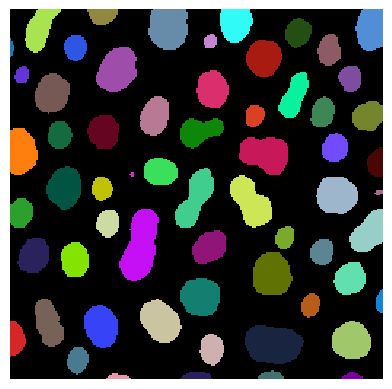

In [9]:
stackview.imshow(labels)

One can also determine label edges and blend them over the image.

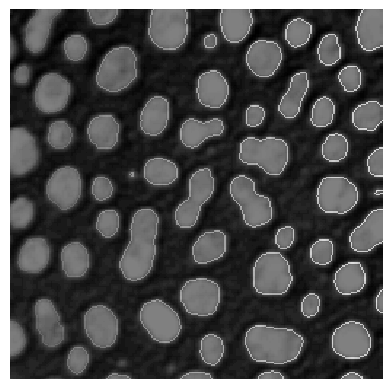

In [10]:
label_edges = cle.detect_label_edges(labels) * labels

stackview.imshow(image, continue_drawing=True)
stackview.imshow(label_edges, alpha=0.5)

Therefore, it may make sense to increase the figure and combine multiple sub-plots

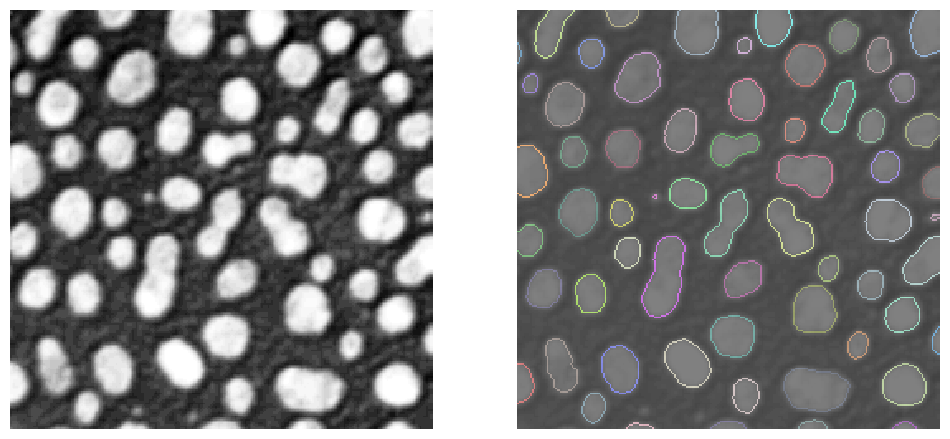

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))

# left plot
stackview.imshow(image, plot=axs[0])

# right plot
stackview.imshow(image, alpha=0.5, continue_drawing=True, plot=axs[1])
stackview.imshow(label_edges, labels=True, alpha=0.5, plot=axs[1])

Some of these operations, e.g. [voronoi_otsu_labeling](https://nbviewer.jupyter.org/github/clEsperanto/pyclesperanto_prototype/blob/master/demo/segmentation/voronoi_otsu_labeling.ipynb) are in fact short-cuts and combine a number of operations such as Gaussian blur, Voronoi-labeling and Otsu-thresholding to go from a raw image to a label image directly:

cl.OCLArray([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
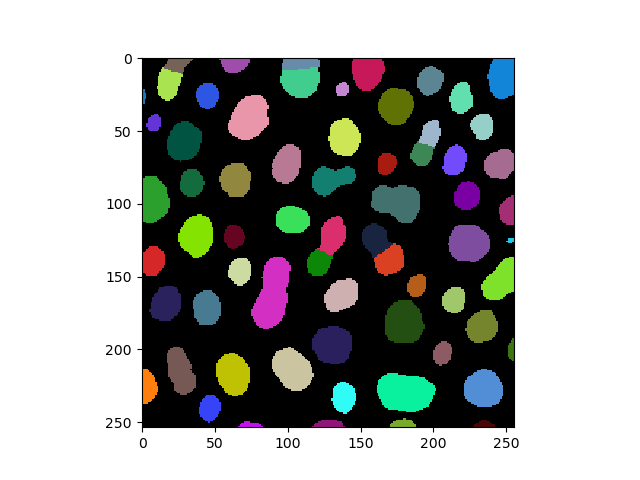

In [12]:
labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5, outline_sigma=1)
labels

Also, just a reminder, read the documentation of methods you haven't used before:

In [13]:
print(cle.voronoi_otsu_labeling.__doc__)

Labels objects directly from grey-value images.

    The two sigma parameters allow tuning the segmentation result. Under the hood,
    this filter applies two Gaussian blurs, spot detection, Otsu-thresholding [2] and Voronoi-labeling [3]. The
    thresholded binary image is flooded using the Voronoi tesselation approach starting from the found local maxima.

    Notes
    -----
    * This operation assumes input images are isotropic.

    Parameters
    ----------
    source : Image
        Input grey-value image
    label_image_destination : Image, optional
        Output image
    spot_sigma : float, optional
        controls how close detected cells can be
    outline_sigma : float, optional
        controls how precise segmented objects are outlined.
    
    Returns
    -------
    label_image_destination
    
    Examples
    --------
    >>> import pyclesperanto_prototype as cle
    >>> cle.voronoi_otsu_labeling(source, label_image_destination, 10, 2)
    
    References
    --

## Interoperability 
In pyclesperanto, images are handled in the random access memory (RAM) of your GPU. If you want to use other libraries, which process images on the GPU, the memory must be transferred back. Usually, this happens transparently for the user, e.g. when using scikit-image for measuring region properties:

In [14]:
from skimage.measure import regionprops

statistics = regionprops(labels)

import numpy as np
np.mean([s.area for s in statistics])

333.77272727272725

If you want to explicitly convert your image, e.g. into a numpy array, you can do it like this:

In [15]:
np.asarray(labels)

array([[ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       [ 0,  0,  0, ..., 62, 62, 62],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)

## Memory management
In jupyter noteboooks, variables are kept alive as long as the notebook kernel is running. Thus, your GPU may fill up with memory. Thus, if you don't need an image anymore, remove it from memory using `del`. It will then be remove from GPU memory thanks to [pyopencl](https://documen.tician.de/pyopencl/) magic.

In [16]:
del image
del blurred
del binary
del labels